In [1]:
# Import required libraries
%pip install optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import optuna
import random

# For models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Set constant seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Downgrade numpy for TensorFlow compatibility (run this cell and restart kernel)
%pip install numpy==1.26.4


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Load dataset and select top 14 features
features = ['RiskScore', 'MonthlyCharges', 'EstimatedCLV', 'tenure', 'ContractRisk', 'PaymentRisk', 'PhoneService', 'AvgChargesPerMonth', 'TechSupport', 'OnlineSecurity', 'TotalCharges', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']
df = pd.read_csv('final_telco_engineered.csv')
X = df[features]
# Assuming target column is 'Churn' (update if different)
y = df['Churn']

In [4]:
# Identify categorical and numerical columns for preprocessing
categorical_cols = ['SeniorCitizen', 'PhoneService', 'TechSupport', 'OnlineSecurity', 'PaperlessBilling', 'PaymentMethod']
numerical_cols = [col for col in features if col not in categorical_cols]

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
])

In [5]:
# Train/validation/test split (80/10/10)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.10, random_state=SEED, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, random_state=SEED, stratify=y_temp)
# 0.1111 * 0.90 ≈ 0.10

In [6]:
# Ensure target variable is numeric (0/1)
if y_train.dtype == 'O' or y_train.dtype.name == 'category':
    y_train = y_train.map({'No': 0, 'Yes': 1}).astype(int)
    y_val = y_val.map({'No': 0, 'Yes': 1}).astype(int)
    y_test = y_test.map({'No': 0, 'Yes': 1}).astype(int)

In [7]:
# Fit preprocessor on ORIGINAL training data (before oversampling)
# This ensures scaling parameters reflect true feature distribution
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)

# Now apply random oversampling to balance classes 50/50 on PREPROCESSED training data
from sklearn.utils import resample

# Show class distribution before oversampling
print("Before oversampling:")
print(pd.Series(y_train).value_counts())
print(pd.Series(y_train).value_counts(normalize=True))

# Combine preprocessed X_train and y_train for resampling
_df_train = pd.DataFrame(X_train_proc)
_df_train['Churn'] = y_train.reset_index(drop=True)
_df_majority = _df_train[_df_train['Churn'] == 0]
_df_minority = _df_train[_df_train['Churn'] == 1]

# Upsample minority to match majority count
_df_minority_up = resample(
    _df_minority,
    replace=True,
    n_samples=len(_df_majority),
    random_state=SEED,
)

# Recombine and shuffle
_df_balanced = pd.concat([_df_majority, _df_minority_up], axis=0)
_df_balanced = _df_balanced.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Split back into features/target
X_train_proc = _df_balanced.drop(columns=['Churn']).values
y_train = _df_balanced['Churn'].astype(int).values

print("\nAfter oversampling:")
print(pd.Series(y_train).value_counts())
print(pd.Series(y_train).value_counts(normalize=True))


Before oversampling:
Churn
0    4138
1    1495
Name: count, dtype: int64
Churn
0    0.7346
1    0.2654
Name: proportion, dtype: float64

After oversampling:
0    4138
1    4138
Name: count, dtype: int64
0    0.5
1    0.5
Name: proportion, dtype: float64



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[I 2025-12-04 15:57:38,927] A new study created in memory with name: no-name-c07ef615-4c20-4ac7-ad3a-c4ed960f74e6
  0%|          | 0/50 [00:00<?, ?it/s]2025-12-04 15:57:38.949582: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-12-04 15:57:38.949637: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-12-04 15:57:38.949657: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-12-04 15:57:38.949679: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-04 15

Early stopping at epoch 11; best val F1=0.6437
Trial early stopped at epoch 11 (best val F1=0.6437)
[I 2025-12-04 15:57:57,859] Trial 0 finished with value: 0.6437246963562753 and parameters: {'n_units': 58, 'lr': 0.007969454818643935, 'dropout': 0.36599697090570255, 'batch_size': 90}. Best is trial 0 with value: 0.6437246963562753.


Best trial: 0. Best value: 0.643725:   4%|▍         | 2/50 [00:39<16:01, 20.04s/it]

Early stopping at epoch 8; best val F1=0.6351
Trial early stopped at epoch 8 (best val F1=0.6351)
[I 2025-12-04 15:58:18,666] Trial 1 finished with value: 0.6350515463917525 and parameters: {'n_units': 33, 'lr': 0.00020511104188433984, 'dropout': 0.02904180608409973, 'batch_size': 116}. Best is trial 0 with value: 0.6437246963562753.


Best trial: 0. Best value: 0.643725:   6%|▌         | 3/50 [00:51<12:41, 16.20s/it]

Early stopping at epoch 6; best val F1=0.6225
Trial early stopped at epoch 6 (best val F1=0.6225)
[I 2025-12-04 15:58:30,313] Trial 2 finished with value: 0.6224899598393574 and parameters: {'n_units': 83, 'lr': 0.0026070247583707684, 'dropout': 0.010292247147901223, 'batch_size': 126}. Best is trial 0 with value: 0.6437246963562753.


Best trial: 0. Best value: 0.643725:   8%|▊         | 4/50 [01:22<17:04, 22.27s/it]

Early stopping at epoch 10; best val F1=0.6392
Trial early stopped at epoch 10 (best val F1=0.6392)
[I 2025-12-04 15:59:01,888] Trial 3 finished with value: 0.6391752577319587 and parameters: {'n_units': 110, 'lr': 0.00026587543983272726, 'dropout': 0.09091248360355031, 'batch_size': 49}. Best is trial 0 with value: 0.6437246963562753.


Best trial: 0. Best value: 0.643725:  10%|█         | 5/50 [01:44<16:24, 21.87s/it]

Early stopping at epoch 7; best val F1=0.6268
Trial early stopped at epoch 7 (best val F1=0.6268)
[I 2025-12-04 15:59:23,057] Trial 4 finished with value: 0.6268041237113402 and parameters: {'n_units': 50, 'lr': 0.0011207606211860567, 'dropout': 0.21597250932105788, 'batch_size': 60}. Best is trial 0 with value: 0.6437246963562753.


Best trial: 5. Best value: 0.64557:  12%|█▏        | 6/50 [02:06<16:04, 21.93s/it] 

Early stopping at epoch 9; best val F1=0.6456
Trial early stopped at epoch 9 (best val F1=0.6456)
[I 2025-12-04 15:59:45,091] Trial 5 finished with value: 0.6455696202531646 and parameters: {'n_units': 85, 'lr': 0.00019010245319870352, 'dropout': 0.14607232426760908, 'batch_size': 67}. Best is trial 5 with value: 0.6455696202531646.


Best trial: 5. Best value: 0.64557:  14%|█▍        | 7/50 [02:37<17:49, 24.87s/it]

Early stopping at epoch 15; best val F1=0.6382
Trial early stopped at epoch 15 (best val F1=0.6382)
[I 2025-12-04 16:00:16,025] Trial 6 finished with value: 0.6382113821138211 and parameters: {'n_units': 67, 'lr': 0.0037183641805732083, 'dropout': 0.09983689107917987, 'batch_size': 81}. Best is trial 5 with value: 0.6455696202531646.


Best trial: 5. Best value: 0.64557:  16%|█▌        | 8/50 [03:20<21:28, 30.68s/it]

Early stopping at epoch 14; best val F1=0.6403
Trial early stopped at epoch 14 (best val F1=0.6403)
[I 2025-12-04 16:00:59,139] Trial 7 finished with value: 0.6403326403326404 and parameters: {'n_units': 82, 'lr': 0.0001238513729886094, 'dropout': 0.3037724259507192, 'batch_size': 48}. Best is trial 5 with value: 0.6455696202531646.


Best trial: 5. Best value: 0.64557:  18%|█▊        | 9/50 [03:34<17:33, 25.69s/it]

Early stopping at epoch 7; best val F1=0.6411
Trial early stopped at epoch 7 (best val F1=0.6411)
[I 2025-12-04 16:01:13,852] Trial 8 finished with value: 0.6411290322580645 and parameters: {'n_units': 23, 'lr': 0.007902619549708232, 'dropout': 0.4828160165372797, 'batch_size': 110}. Best is trial 5 with value: 0.6455696202531646.


Best trial: 5. Best value: 0.64557:  20%|██        | 10/50 [04:09<18:52, 28.32s/it]

Early stopping at epoch 15; best val F1=0.6446
Trial early stopped at epoch 15 (best val F1=0.6446)
[I 2025-12-04 16:01:48,051] Trial 9 finished with value: 0.6446280991735537 and parameters: {'n_units': 50, 'lr': 0.0001567993391672301, 'dropout': 0.34211651325607845, 'batch_size': 74}. Best is trial 5 with value: 0.6455696202531646.


Best trial: 5. Best value: 0.64557:  22%|██▏       | 11/50 [04:39<18:43, 28.81s/it]

Early stopping at epoch 6; best val F1=0.6320
Trial early stopped at epoch 6 (best val F1=0.6320)
[I 2025-12-04 16:02:17,974] Trial 10 finished with value: 0.632016632016632 and parameters: {'n_units': 124, 'lr': 0.0005338943774556114, 'dropout': 0.18626884362117777, 'batch_size': 33}. Best is trial 5 with value: 0.6455696202531646.


Best trial: 5. Best value: 0.64557:  24%|██▍       | 12/50 [05:01<16:59, 26.82s/it]

Early stopping at epoch 8; best val F1=0.6340
Trial early stopped at epoch 8 (best val F1=0.6340)
[I 2025-12-04 16:02:40,256] Trial 11 finished with value: 0.6340425531914894 and parameters: {'n_units': 96, 'lr': 0.00011952270129143859, 'dropout': 0.3945277558981823, 'batch_size': 68}. Best is trial 5 with value: 0.6455696202531646.


Best trial: 5. Best value: 0.64557:  26%|██▌       | 13/50 [05:41<18:57, 30.74s/it]

Early stopping at epoch 19; best val F1=0.6402
Trial early stopped at epoch 19 (best val F1=0.6402)
[I 2025-12-04 16:03:20,012] Trial 12 finished with value: 0.6401673640167364 and parameters: {'n_units': 41, 'lr': 0.0005102555764977567, 'dropout': 0.2661618599459743, 'batch_size': 91}. Best is trial 5 with value: 0.6455696202531646.


Best trial: 5. Best value: 0.64557:  28%|██▊       | 14/50 [06:03<16:58, 28.30s/it]

Early stopping at epoch 7; best val F1=0.6408
Trial early stopped at epoch 7 (best val F1=0.6408)
[I 2025-12-04 16:03:42,655] Trial 13 finished with value: 0.6408163265306123 and parameters: {'n_units': 74, 'lr': 0.00030680514782256723, 'dropout': 0.14050029297606484, 'batch_size': 73}. Best is trial 5 with value: 0.6455696202531646.


Best trial: 5. Best value: 0.64557:  30%|███       | 15/50 [06:25<15:19, 26.28s/it]

Early stopping at epoch 6; best val F1=0.6383
Trial early stopped at epoch 6 (best val F1=0.6383)
[I 2025-12-04 16:04:04,260] Trial 14 finished with value: 0.6382978723404256 and parameters: {'n_units': 97, 'lr': 0.0008833351672165309, 'dropout': 0.35171324184969505, 'batch_size': 94}. Best is trial 5 with value: 0.6455696202531646.


Best trial: 5. Best value: 0.64557:  32%|███▏      | 16/50 [06:57<15:54, 28.08s/it]

Early stopping at epoch 10; best val F1=0.6351
Trial early stopped at epoch 10 (best val F1=0.6351)
[I 2025-12-04 16:04:36,532] Trial 15 finished with value: 0.6350515463917525 and parameters: {'n_units': 60, 'lr': 0.00010438120620105172, 'dropout': 0.46142412607356953, 'batch_size': 58}. Best is trial 5 with value: 0.6455696202531646.


Best trial: 5. Best value: 0.64557:  34%|███▍      | 17/50 [07:32<16:34, 30.13s/it]

Early stopping at epoch 15; best val F1=0.6347
Trial early stopped at epoch 15 (best val F1=0.6347)
[I 2025-12-04 16:05:11,426] Trial 16 finished with value: 0.6346555323590815 and parameters: {'n_units': 21, 'lr': 0.000202694987755722, 'dropout': 0.2824022635426643, 'batch_size': 80}. Best is trial 5 with value: 0.6455696202531646.


Best trial: 5. Best value: 0.64557:  36%|███▌      | 18/50 [08:02<16:04, 30.13s/it]

Early stopping at epoch 6; best val F1=0.6347
Trial early stopped at epoch 6 (best val F1=0.6347)
[I 2025-12-04 16:05:41,565] Trial 17 finished with value: 0.6346555323590815 and parameters: {'n_units': 45, 'lr': 0.000403973827395192, 'dropout': 0.17724751568785632, 'batch_size': 33}. Best is trial 5 with value: 0.6455696202531646.


Best trial: 5. Best value: 0.64557:  38%|███▊      | 19/50 [08:18<13:18, 25.77s/it]

Early stopping at epoch 6; best val F1=0.6351
Trial early stopped at epoch 6 (best val F1=0.6351)
[I 2025-12-04 16:05:57,179] Trial 18 finished with value: 0.6350515463917525 and parameters: {'n_units': 99, 'lr': 0.0009575289480124525, 'dropout': 0.4219900508555974, 'batch_size': 98}. Best is trial 5 with value: 0.6455696202531646.


Best trial: 19. Best value: 0.646091:  40%|████      | 20/50 [09:08<16:36, 33.21s/it]

Early stopping at epoch 19; best val F1=0.6461
Trial early stopped at epoch 19 (best val F1=0.6461)
[I 2025-12-04 16:06:47,733] Trial 19 finished with value: 0.6460905349794238 and parameters: {'n_units': 80, 'lr': 0.0001763233417269329, 'dropout': 0.23105737920056402, 'batch_size': 66}. Best is trial 19 with value: 0.6460905349794238.


Best trial: 19. Best value: 0.646091:  42%|████▏     | 21/50 [09:40<15:53, 32.88s/it]

Early stopping at epoch 7; best val F1=0.6364
Trial early stopped at epoch 7 (best val F1=0.6364)
[I 2025-12-04 16:07:19,820] Trial 20 finished with value: 0.6363636363636364 and parameters: {'n_units': 84, 'lr': 0.0020065771485986692, 'dropout': 0.22711994509351616, 'batch_size': 47}. Best is trial 19 with value: 0.6460905349794238.


Best trial: 19. Best value: 0.646091:  44%|████▍     | 22/50 [10:13<15:18, 32.80s/it]

Early stopping at epoch 9; best val F1=0.6390
Trial early stopped at epoch 9 (best val F1=0.6390)
[I 2025-12-04 16:07:52,444] Trial 21 finished with value: 0.6390041493775933 and parameters: {'n_units': 71, 'lr': 0.00016047779097225537, 'dropout': 0.3308851073086485, 'batch_size': 66}. Best is trial 19 with value: 0.6460905349794238.


Best trial: 22. Best value: 0.647423:  46%|████▌     | 23/50 [10:38<13:44, 30.53s/it]

Early stopping at epoch 9; best val F1=0.6474
Trial early stopped at epoch 9 (best val F1=0.6474)
[I 2025-12-04 16:08:17,669] Trial 22 finished with value: 0.6474226804123712 and parameters: {'n_units': 59, 'lr': 0.00031989396842379766, 'dropout': 0.13345187603777636, 'batch_size': 79}. Best is trial 22 with value: 0.6474226804123712.


Best trial: 23. Best value: 0.64876:  48%|████▊     | 24/50 [11:07<12:59, 29.98s/it] 

Early stopping at epoch 8; best val F1=0.6488
Trial early stopped at epoch 8 (best val F1=0.6488)
[I 2025-12-04 16:08:46,383] Trial 23 finished with value: 0.6487603305785123 and parameters: {'n_units': 109, 'lr': 0.0003321946666333851, 'dropout': 0.11920004131692219, 'batch_size': 58}. Best is trial 23 with value: 0.6487603305785123.


Best trial: 23. Best value: 0.64876:  50%|█████     | 25/50 [11:34<12:05, 29.04s/it]

Early stopping at epoch 7; best val F1=0.6405
Trial early stopped at epoch 7 (best val F1=0.6405)
[I 2025-12-04 16:09:13,220] Trial 24 finished with value: 0.640495867768595 and parameters: {'n_units': 122, 'lr': 0.0003421117149037769, 'dropout': 0.07204408740853288, 'batch_size': 56}. Best is trial 23 with value: 0.6487603305785123.


Best trial: 23. Best value: 0.64876:  52%|█████▏    | 26/50 [11:58<11:04, 27.67s/it]

Early stopping at epoch 8; best val F1=0.6337
Trial early stopped at epoch 8 (best val F1=0.6337)
[I 2025-12-04 16:09:37,687] Trial 25 finished with value: 0.6337448559670782 and parameters: {'n_units': 109, 'lr': 0.0006660156417512484, 'dropout': 0.12952581101821303, 'batch_size': 84}. Best is trial 23 with value: 0.6487603305785123.


Best trial: 23. Best value: 0.64876:  54%|█████▍    | 27/50 [12:49<13:13, 34.50s/it]

Early stopping at epoch 12; best val F1=0.6379
Trial early stopped at epoch 12 (best val F1=0.6379)
[I 2025-12-04 16:10:28,132] Trial 26 finished with value: 0.6378600823045267 and parameters: {'n_units': 112, 'lr': 0.00024926303343685984, 'dropout': 0.06177765639617398, 'batch_size': 43}. Best is trial 23 with value: 0.6487603305785123.


Best trial: 23. Best value: 0.64876:  56%|█████▌    | 28/50 [13:40<14:27, 39.45s/it]

Early stopping at epoch 17; best val F1=0.6405
Trial early stopped at epoch 17 (best val F1=0.6405)
[I 2025-12-04 16:11:19,121] Trial 27 finished with value: 0.640495867768595 and parameters: {'n_units': 63, 'lr': 0.0004149656031869978, 'dropout': 0.17327399815666633, 'batch_size': 61}. Best is trial 23 with value: 0.6487603305785123.


Best trial: 23. Best value: 0.64876:  58%|█████▊    | 29/50 [13:58<11:37, 33.21s/it]

Early stopping at epoch 6; best val F1=0.6418
Trial early stopped at epoch 6 (best val F1=0.6418)
[I 2025-12-04 16:11:37,796] Trial 28 finished with value: 0.6418219461697723 and parameters: {'n_units': 91, 'lr': 0.0007408656233096632, 'dropout': 0.23832571349686027, 'batch_size': 104}. Best is trial 23 with value: 0.6487603305785123.


Best trial: 23. Best value: 0.64876:  60%|██████    | 30/50 [14:20<09:52, 29.64s/it]

Early stopping at epoch 6; best val F1=0.6278
Trial early stopped at epoch 6 (best val F1=0.6278)
[I 2025-12-04 16:11:59,081] Trial 29 finished with value: 0.6277665995975855 and parameters: {'n_units': 75, 'lr': 0.001524176783121479, 'dropout': 0.20684727825819366, 'batch_size': 73}. Best is trial 23 with value: 0.6487603305785123.


Best trial: 23. Best value: 0.64876:  62%|██████▏   | 31/50 [14:43<08:48, 27.84s/it]

Early stopping at epoch 7; best val F1=0.6477
Trial early stopped at epoch 7 (best val F1=0.6477)
[I 2025-12-04 16:12:22,733] Trial 30 finished with value: 0.6476578411405295 and parameters: {'n_units': 55, 'lr': 0.0005463657195806048, 'dropout': 0.05443517054368105, 'batch_size': 85}. Best is trial 23 with value: 0.6487603305785123.


Best trial: 23. Best value: 0.64876:  64%|██████▍   | 32/50 [15:40<10:54, 36.36s/it]

Early stopping at epoch 19; best val F1=0.6430
Trial early stopped at epoch 19 (best val F1=0.6430)
[I 2025-12-04 16:13:18,976] Trial 31 finished with value: 0.6430062630480167 and parameters: {'n_units': 58, 'lr': 0.0005271753275800178, 'dropout': 0.03779166439199788, 'batch_size': 87}. Best is trial 23 with value: 0.6487603305785123.


Best trial: 23. Best value: 0.64876:  66%|██████▌   | 33/50 [16:15<10:14, 36.12s/it]

Early stopping at epoch 12; best val F1=0.6403
Trial early stopped at epoch 12 (best val F1=0.6403)
[I 2025-12-04 16:13:54,527] Trial 32 finished with value: 0.6403326403326404 and parameters: {'n_units': 38, 'lr': 0.00027278454886369124, 'dropout': 0.10344814370704562, 'batch_size': 74}. Best is trial 23 with value: 0.6487603305785123.


Best trial: 23. Best value: 0.64876:  68%|██████▊   | 34/50 [16:52<09:41, 36.36s/it]

Early stopping at epoch 9; best val F1=0.6383
Trial early stopped at epoch 9 (best val F1=0.6383)
[I 2025-12-04 16:14:31,454] Trial 33 finished with value: 0.6382978723404256 and parameters: {'n_units': 51, 'lr': 0.0003825877072022093, 'dropout': 0.007510605812843657, 'batch_size': 80}. Best is trial 23 with value: 0.6487603305785123.


Best trial: 23. Best value: 0.64876:  70%|███████   | 35/50 [17:44<10:15, 41.02s/it]

Early stopping at epoch 21; best val F1=0.6390
Trial early stopped at epoch 21 (best val F1=0.6390)
[I 2025-12-04 16:15:23,348] Trial 34 finished with value: 0.6390041493775933 and parameters: {'n_units': 30, 'lr': 0.0002233461703835351, 'dropout': 0.04491470850747237, 'batch_size': 100}. Best is trial 23 with value: 0.6487603305785123.


Best trial: 23. Best value: 0.64876:  72%|███████▏  | 36/50 [18:19<09:09, 39.25s/it]

Early stopping at epoch 17; best val F1=0.6347
Trial early stopped at epoch 17 (best val F1=0.6347)
[I 2025-12-04 16:15:58,476] Trial 35 finished with value: 0.6346555323590815 and parameters: {'n_units': 54, 'lr': 0.00014890086944313388, 'dropout': 0.11652787070445547, 'batch_size': 126}. Best is trial 23 with value: 0.6487603305785123.


Best trial: 23. Best value: 0.64876:  74%|███████▍  | 37/50 [18:53<08:08, 37.60s/it]

Early stopping at epoch 7; best val F1=0.6309
Trial early stopped at epoch 7 (best val F1=0.6309)
[I 2025-12-04 16:16:32,212] Trial 36 finished with value: 0.6309278350515464 and parameters: {'n_units': 105, 'lr': 0.0006045848513220327, 'dropout': 0.15741686587554896, 'batch_size': 52}. Best is trial 23 with value: 0.6487603305785123.


Best trial: 23. Best value: 0.64876:  76%|███████▌  | 38/50 [19:22<07:01, 35.10s/it]

Early stopping at epoch 7; best val F1=0.6230
Trial early stopped at epoch 7 (best val F1=0.6230)
[I 2025-12-04 16:17:01,482] Trial 37 finished with value: 0.6229508196721312 and parameters: {'n_units': 78, 'lr': 0.0012506943897913577, 'dropout': 0.08103426473682365, 'batch_size': 62}. Best is trial 23 with value: 0.6487603305785123.


Best trial: 23. Best value: 0.64876:  78%|███████▊  | 39/50 [20:03<06:45, 36.90s/it]

Early stopping at epoch 8; best val F1=0.6433
Trial early stopped at epoch 8 (best val F1=0.6433)
[I 2025-12-04 16:17:42,576] Trial 38 finished with value: 0.643298969072165 and parameters: {'n_units': 62, 'lr': 0.0003052794359957855, 'dropout': 0.19631265388932762, 'batch_size': 39}. Best is trial 23 with value: 0.6487603305785123.


Best trial: 23. Best value: 0.64876:  80%|████████  | 40/50 [20:29<05:35, 33.54s/it]

Early stopping at epoch 7; best val F1=0.6392
Trial early stopped at epoch 7 (best val F1=0.6392)
[I 2025-12-04 16:18:08,272] Trial 39 finished with value: 0.6391752577319587 and parameters: {'n_units': 119, 'lr': 0.0004540906214403676, 'dropout': 0.02584525923942589, 'batch_size': 67}. Best is trial 23 with value: 0.6487603305785123.


Best trial: 23. Best value: 0.64876:  82%|████████▏ | 41/50 [21:02<05:00, 33.36s/it]

Early stopping at epoch 8; best val F1=0.6448
Trial early stopped at epoch 8 (best val F1=0.6448)
[I 2025-12-04 16:18:41,213] Trial 40 finished with value: 0.6447638603696099 and parameters: {'n_units': 66, 'lr': 0.00019469335798784023, 'dropout': 0.11773950490054085, 'batch_size': 55}. Best is trial 23 with value: 0.6487603305785123.


Best trial: 23. Best value: 0.64876:  84%|████████▍ | 42/50 [21:35<04:26, 33.30s/it]

Early stopping at epoch 11; best val F1=0.6375
Trial early stopped at epoch 11 (best val F1=0.6375)
[I 2025-12-04 16:19:14,368] Trial 41 finished with value: 0.6375 and parameters: {'n_units': 88, 'lr': 0.00017852126096697184, 'dropout': 0.14390528977994152, 'batch_size': 77}. Best is trial 23 with value: 0.6487603305785123.


Best trial: 23. Best value: 0.64876:  86%|████████▌ | 43/50 [22:20<04:18, 36.90s/it]

Early stopping at epoch 13; best val F1=0.6402
Trial early stopped at epoch 13 (best val F1=0.6402)
[I 2025-12-04 16:19:59,663] Trial 42 finished with value: 0.6401673640167364 and parameters: {'n_units': 68, 'lr': 0.00024398356167614125, 'dropout': 0.09153036868979239, 'batch_size': 69}. Best is trial 23 with value: 0.6487603305785123.


Best trial: 23. Best value: 0.64876:  88%|████████▊ | 44/50 [23:58<05:30, 55.12s/it]

Early stopping at epoch 24; best val F1=0.6444
Trial early stopped at epoch 24 (best val F1=0.6444)
[I 2025-12-04 16:21:37,307] Trial 43 finished with value: 0.6443514644351465 and parameters: {'n_units': 79, 'lr': 0.000134838310536167, 'dropout': 0.2539879758174606, 'batch_size': 86}. Best is trial 23 with value: 0.6487603305785123.


Best trial: 23. Best value: 0.64876:  90%|█████████ | 45/50 [25:01<04:46, 57.39s/it]

Early stopping at epoch 17; best val F1=0.6432
Trial early stopped at epoch 17 (best val F1=0.6432)
[I 2025-12-04 16:22:39,982] Trial 44 finished with value: 0.6431535269709544 and parameters: {'n_units': 45, 'lr': 0.0003329705284101542, 'dropout': 0.153496475076342, 'batch_size': 63}. Best is trial 23 with value: 0.6487603305785123.


Best trial: 23. Best value: 0.64876:  92%|█████████▏| 46/50 [25:51<03:40, 55.18s/it]

Early stopping at epoch 10; best val F1=0.6380
Trial early stopped at epoch 10 (best val F1=0.6380)
[I 2025-12-04 16:23:30,001] Trial 45 finished with value: 0.6380368098159509 and parameters: {'n_units': 128, 'lr': 0.003405676169723664, 'dropout': 0.06397926187189545, 'batch_size': 91}. Best is trial 23 with value: 0.6487603305785123.


Best trial: 23. Best value: 0.64876:  94%|█████████▍| 47/50 [26:48<02:47, 55.89s/it]

Early stopping at epoch 9; best val F1=0.6300
Trial early stopped at epoch 9 (best val F1=0.6300)
[I 2025-12-04 16:24:27,550] Trial 46 finished with value: 0.6300211416490487 and parameters: {'n_units': 87, 'lr': 0.00010012078005753865, 'dropout': 0.2978569458407371, 'batch_size': 72}. Best is trial 23 with value: 0.6487603305785123.


Best trial: 23. Best value: 0.64876:  96%|█████████▌| 48/50 [27:14<01:33, 46.91s/it]

Early stopping at epoch 6; best val F1=0.6441
Trial early stopped at epoch 6 (best val F1=0.6441)
[I 2025-12-04 16:24:53,511] Trial 47 finished with value: 0.6440677966101694 and parameters: {'n_units': 55, 'lr': 0.009593019506630766, 'dropout': 0.1076499856475434, 'batch_size': 83}. Best is trial 23 with value: 0.6487603305785123.


Best trial: 23. Best value: 0.64876:  98%|█████████▊| 49/50 [27:52<00:44, 44.20s/it]

Early stopping at epoch 15; best val F1=0.6388
Trial early stopped at epoch 15 (best val F1=0.6388)
[I 2025-12-04 16:25:31,395] Trial 48 finished with value: 0.6388308977035491 and parameters: {'n_units': 93, 'lr': 0.0008069304303612848, 'dropout': 0.16568709970701115, 'batch_size': 115}. Best is trial 23 with value: 0.6487603305785123.


Best trial: 23. Best value: 0.64876: 100%|██████████| 50/50 [28:38<00:00, 34.36s/it]

Early stopping at epoch 12; best val F1=0.6390
Trial early stopped at epoch 12 (best val F1=0.6390)
[I 2025-12-04 16:26:17,180] Trial 49 finished with value: 0.6390041493775933 and parameters: {'n_units': 104, 'lr': 0.0001841715048189761, 'dropout': 0.21348586376473566, 'batch_size': 78}. Best is trial 23 with value: 0.6487603305785123.
Best FNN hyperparameters: {'n_units': 109, 'lr': 0.0003321946666333851, 'dropout': 0.11920004131692219, 'batch_size': 58}


Early stopping at epoch 10; best val F1=0.6351
Final FNN early stopped at epoch 10 (best val F1=0.6351)
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
FNN Test Results:
Accuracy: 0.7574
F1 Score: 0.6338
Precision: 0.5286
Recall (Sensitivity): 0.7914
Specificity: 0.7452
AUC: 0.8474


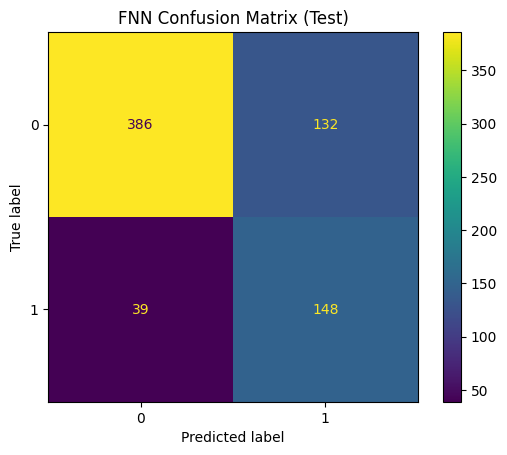

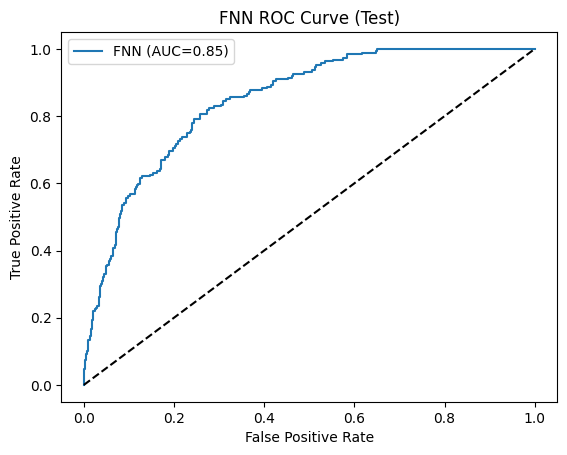

In [8]:
# Feed Forward Neural Network (FNN) with Optuna hyperparameter tuning (F1-based)
%pip install tensorflow-macos tensorflow-metal
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Deterministic TensorFlow config
tf.keras.utils.set_random_seed(SEED)
try:
    tf.config.experimental.enable_op_determinism()
except Exception:
    pass
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

# Class weights removed (data already oversampled to balance classes)

class F1EarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val, patience=5):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.patience = patience
        self.best_f1 = -1
        self.wait = 0
        self.best_weights = None
        self.stopped_epoch = None
    def on_epoch_end(self, epoch, logs=None):
        preds = (self.model.predict(self.X_val, verbose=0).ravel() > 0.5).astype(int)
        current_f1 = f1_score(self.y_val, preds)
        if current_f1 > self.best_f1:
            self.best_f1 = current_f1
            self.best_weights = self.model.get_weights()
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch + 1
                print(f'Early stopping at epoch {self.stopped_epoch}; best val F1={self.best_f1:.4f}')
                self.model.stop_training = True

def create_fnn_model(trial):
    n_units = trial.suggest_int('n_units', 16, 128)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    model = models.Sequential([
        layers.Input(shape=(X_train_proc.shape[1],)),
        layers.Dense(n_units, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(1, activation='sigmoid')
    ])
    optimizer = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=losses.BinaryCrossentropy(), metrics=['accuracy'])
    return model

def objective_fnn(trial):
    model = create_fnn_model(trial)
    f1_callback = F1EarlyStopping(X_val_proc, y_val, patience=5)
    model.fit(
        X_train_proc, y_train,
        validation_data=(X_val_proc, y_val),
        epochs=30,
        batch_size=trial.suggest_int('batch_size', 32, 128),
        verbose=0,
        callbacks=[f1_callback]
    )
    if f1_callback.stopped_epoch is not None:
        print(f'Trial early stopped at epoch {f1_callback.stopped_epoch} (best val F1={f1_callback.best_f1:.4f})')
    if f1_callback.best_weights is not None:
        model.set_weights(f1_callback.best_weights)
    return f1_callback.best_f1

study_fnn = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_fnn.optimize(objective_fnn, n_trials=50, show_progress_bar=True)

best_params_fnn = study_fnn.best_params
print('Best FNN hyperparameters:', best_params_fnn)
best_fnn = create_fnn_model(optuna.trial.FixedTrial(best_params_fnn))
f1_callback_final = F1EarlyStopping(X_val_proc, y_val, patience=5)
best_fnn.fit(
    X_train_proc, y_train,
    validation_data=(X_val_proc, y_val),
    epochs=30,
    batch_size=best_params_fnn['batch_size'],
    verbose=0,
    callbacks=[f1_callback_final]
)
if f1_callback_final.stopped_epoch is not None:
    print(f'Final FNN early stopped at epoch {f1_callback_final.stopped_epoch} (best val F1={f1_callback_final.best_f1:.4f})')
if f1_callback_final.best_weights is not None:
    best_fnn.set_weights(f1_callback_final.best_weights)

pred_test_fnn = best_fnn.predict(X_test_proc).ravel()
pred_test_label_fnn = (pred_test_fnn > 0.5).astype(int)
cm_fnn = confusion_matrix(y_test, pred_test_label_fnn)
roc_auc_fnn = roc_auc_score(y_test, pred_test_fnn)
f1_fnn = f1_score(y_test, pred_test_label_fnn)
precision_fnn = precision_score(y_test, pred_test_label_fnn)
recall_fnn = recall_score(y_test, pred_test_label_fnn)
specificity_fnn = cm_fnn[0,0] / (cm_fnn[0,0] + cm_fnn[0,1]) if (cm_fnn[0,0] + cm_fnn[0,1]) > 0 else 0
accuracy_fnn = (cm_fnn[0,0] + cm_fnn[1,1]) / cm_fnn.sum()
print('FNN Test Results:')
print(f'Accuracy: {accuracy_fnn:.4f}')
print(f'F1 Score: {f1_fnn:.4f}')
print(f'Precision: {precision_fnn:.4f}')
print(f'Recall (Sensitivity): {recall_fnn:.4f}')
print(f'Specificity: {specificity_fnn:.4f}')
print(f'AUC: {roc_auc_fnn:.4f}')
ConfusionMatrixDisplay(cm_fnn).plot()
plt.title('FNN Confusion Matrix (Test)')
plt.show()
fpr_fnn, tpr_fnn, _ = roc_curve(y_test, pred_test_fnn)
plt.figure()
plt.plot(fpr_fnn, tpr_fnn, label=f'FNN (AUC={roc_auc_fnn:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('FNN ROC Curve (Test)')
plt.legend()
plt.show()


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[I 2025-12-04 16:32:28,433] A new study created in memory with name: no-name-a3b56066-c3cd-4df6-9aa9-c19ade30d2da
  0%|          | 0/50 [00:00<?, ?it/s]2025-12-04 16:32:28.465358: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-12-04 16:32:28.465418: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-12-04 16:32:28.465435: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-12-04 16:32:28.465469: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-04 16

Early stopping at epoch 6; best val F1=0.6634
Trial early stopped at epoch 6 (best val F1=0.6634)
[I 2025-12-04 16:32:57,454] Trial 0 finished with value: 0.6634146341463415 and parameters: {'n_layers': 3, 'n_units': 124, 'lr': 0.0029106359131330704, 'dropout': 0.2993292420985183, 'batch_size': 47}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:   4%|▍         | 2/50 [00:53<21:08, 26.42s/it]

Early stopping at epoch 11; best val F1=0.6430
Trial early stopped at epoch 11 (best val F1=0.6430)
[I 2025-12-04 16:33:22,070] Trial 1 finished with value: 0.6430062630480167 and parameters: {'n_layers': 2, 'n_units': 37, 'lr': 0.005399484409787433, 'dropout': 0.3005575058716044, 'batch_size': 100}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:   6%|▌         | 3/50 [01:33<25:21, 32.36s/it]

Early stopping at epoch 7; best val F1=0.6462
Trial early stopped at epoch 7 (best val F1=0.6462)
[I 2025-12-04 16:34:01,492] Trial 2 finished with value: 0.6462264150943396 and parameters: {'n_layers': 2, 'n_units': 126, 'lr': 0.004622589001020831, 'dropout': 0.10616955533913808, 'batch_size': 49}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:   8%|▊         | 4/50 [02:32<32:54, 42.93s/it]

Early stopping at epoch 18; best val F1=0.6446
Trial early stopped at epoch 18 (best val F1=0.6446)
[I 2025-12-04 16:35:00,636] Trial 3 finished with value: 0.6446280991735537 and parameters: {'n_layers': 2, 'n_units': 61, 'lr': 0.0011207606211860567, 'dropout': 0.21597250932105788, 'batch_size': 60}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  10%|█         | 5/50 [03:34<37:31, 50.04s/it]

Early stopping at epoch 19; best val F1=0.6473
Trial early stopped at epoch 19 (best val F1=0.6473)
[I 2025-12-04 16:36:03,269] Trial 4 finished with value: 0.6473029045643154 and parameters: {'n_layers': 3, 'n_units': 45, 'lr': 0.0003839629299804173, 'dropout': 0.18318092164684585, 'batch_size': 76}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  12%|█▏        | 6/50 [04:56<44:42, 60.96s/it]

Early stopping at epoch 12; best val F1=0.6453
Trial early stopped at epoch 12 (best val F1=0.6453)
[I 2025-12-04 16:37:25,444] Trial 5 finished with value: 0.6452991452991453 and parameters: {'n_layers': 4, 'n_units': 51, 'lr': 0.0010677482709481358, 'dropout': 0.29620728443102123, 'batch_size': 36}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  14%|█▍        | 7/50 [05:43<40:16, 56.19s/it]

Early stopping at epoch 20; best val F1=0.6325
Trial early stopped at epoch 20 (best val F1=0.6325)
[I 2025-12-04 16:38:11,815] Trial 6 finished with value: 0.6324786324786325 and parameters: {'n_layers': 3, 'n_units': 48, 'lr': 0.00013492834268013249, 'dropout': 0.4744427686266666, 'batch_size': 125}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  16%|█▌        | 8/50 [06:21<35:14, 50.35s/it]

Early stopping at epoch 8; best val F1=0.6352
Trial early stopped at epoch 8 (best val F1=0.6352)
[I 2025-12-04 16:38:49,664] Trial 7 finished with value: 0.6351931330472103 and parameters: {'n_layers': 4, 'n_units': 61, 'lr': 0.0001567993391672301, 'dropout': 0.34211651325607845, 'batch_size': 74}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  18%|█▊        | 9/50 [07:03<32:43, 47.89s/it]

Early stopping at epoch 10; best val F1=0.6335
Trial early stopped at epoch 10 (best val F1=0.6335)
[I 2025-12-04 16:39:32,147] Trial 8 finished with value: 0.6335403726708074 and parameters: {'n_layers': 2, 'n_units': 80, 'lr': 0.00011715937392307068, 'dropout': 0.45466020103939103, 'batch_size': 57}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  20%|██        | 10/50 [07:49<31:24, 47.11s/it]

Early stopping at epoch 8; best val F1=0.6421
Trial early stopped at epoch 8 (best val F1=0.6421)
[I 2025-12-04 16:40:17,514] Trial 9 finished with value: 0.6421267893660532 and parameters: {'n_layers': 3, 'n_units': 62, 'lr': 0.001096821720752952, 'dropout': 0.2733551396716398, 'batch_size': 49}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  22%|██▏       | 11/50 [08:56<34:37, 53.27s/it]

Early stopping at epoch 7; best val F1=0.6376
Trial early stopped at epoch 7 (best val F1=0.6376)
[I 2025-12-04 16:41:24,752] Trial 10 finished with value: 0.6375545851528385 and parameters: {'n_layers': 4, 'n_units': 122, 'lr': 0.0024673775376624486, 'dropout': 0.0089809378074098, 'batch_size': 33}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  24%|██▍       | 12/50 [09:23<28:39, 45.24s/it]

Early stopping at epoch 7; best val F1=0.6316
Trial early stopped at epoch 7 (best val F1=0.6316)
[I 2025-12-04 16:41:51,638] Trial 11 finished with value: 0.631578947368421 and parameters: {'n_layers': 3, 'n_units': 110, 'lr': 0.00034170489746394937, 'dropout': 0.16739758811161823, 'batch_size': 88}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  26%|██▌       | 13/50 [10:08<27:52, 45.20s/it]

Early stopping at epoch 9; best val F1=0.6377
Trial early stopped at epoch 9 (best val F1=0.6377)
[I 2025-12-04 16:42:36,729] Trial 12 finished with value: 0.6376811594202898 and parameters: {'n_layers': 3, 'n_units': 97, 'lr': 0.00037299981541424096, 'dropout': 0.3674637024294079, 'batch_size': 77}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  28%|██▊       | 14/50 [10:32<23:22, 38.95s/it]

Early stopping at epoch 6; best val F1=0.6409
Trial early stopped at epoch 6 (best val F1=0.6409)
[I 2025-12-04 16:43:01,238] Trial 13 finished with value: 0.6408602150537634 and parameters: {'n_layers': 3, 'n_units': 87, 'lr': 0.002213441220758151, 'dropout': 0.13349553647268478, 'batch_size': 106}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  30%|███       | 15/50 [11:21<24:26, 41.91s/it]

Early stopping at epoch 10; best val F1=0.6531
Trial early stopped at epoch 10 (best val F1=0.6531)
[I 2025-12-04 16:43:50,016] Trial 14 finished with value: 0.6530612244897959 and parameters: {'n_layers': 3, 'n_units': 33, 'lr': 0.0003700926788877892, 'dropout': 0.2157369214087406, 'batch_size': 65}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  32%|███▏      | 16/50 [11:56<22:29, 39.71s/it]

Early stopping at epoch 6; best val F1=0.5740
Trial early stopped at epoch 6 (best val F1=0.5740)
[I 2025-12-04 16:44:24,598] Trial 15 finished with value: 0.5740181268882175 and parameters: {'n_layers': 4, 'n_units': 77, 'lr': 0.009818226878189128, 'dropout': 0.08560194923880418, 'batch_size': 65}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  34%|███▍      | 17/50 [13:14<28:09, 51.19s/it]

Early stopping at epoch 14; best val F1=0.6421
Trial early stopped at epoch 14 (best val F1=0.6421)
[I 2025-12-04 16:45:42,496] Trial 16 finished with value: 0.6421267893660532 and parameters: {'n_layers': 3, 'n_units': 108, 'lr': 0.0005930877546470365, 'dropout': 0.3711481580505469, 'batch_size': 46}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  36%|███▌      | 18/50 [14:32<31:37, 59.30s/it]

Early stopping at epoch 24; best val F1=0.6472
Trial early stopped at epoch 24 (best val F1=0.6472)
[I 2025-12-04 16:47:00,687] Trial 17 finished with value: 0.6471816283924844 and parameters: {'n_layers': 2, 'n_units': 33, 'lr': 0.0017474018762964273, 'dropout': 0.23105737920056402, 'batch_size': 66}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  38%|███▊      | 19/50 [15:35<31:16, 60.55s/it]

Early stopping at epoch 12; best val F1=0.6395
Trial early stopped at epoch 12 (best val F1=0.6395)
[I 2025-12-04 16:48:04,129] Trial 18 finished with value: 0.639511201629328 and parameters: {'n_layers': 4, 'n_units': 95, 'lr': 0.0006641269354248263, 'dropout': 0.39544000967007203, 'batch_size': 89}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  40%|████      | 20/50 [17:12<35:46, 71.55s/it]

Early stopping at epoch 16; best val F1=0.6429
Trial early stopped at epoch 16 (best val F1=0.6429)
[I 2025-12-04 16:49:41,314] Trial 19 finished with value: 0.6428571428571429 and parameters: {'n_layers': 3, 'n_units': 113, 'lr': 0.00021492770862893655, 'dropout': 0.04858366009174672, 'batch_size': 46}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  42%|████▏     | 21/50 [18:31<35:36, 73.66s/it]

Early stopping at epoch 10; best val F1=0.6442
Trial early stopped at epoch 10 (best val F1=0.6442)
[I 2025-12-04 16:50:59,895] Trial 20 finished with value: 0.6442105263157895 and parameters: {'n_layers': 3, 'n_units': 73, 'lr': 0.003917453154792912, 'dropout': 0.4243650491166929, 'batch_size': 40}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  44%|████▍     | 22/50 [19:33<32:42, 70.08s/it]

Early stopping at epoch 13; best val F1=0.6473
Trial early stopped at epoch 13 (best val F1=0.6473)
[I 2025-12-04 16:52:01,622] Trial 21 finished with value: 0.6473029045643154 and parameters: {'n_layers': 3, 'n_units': 42, 'lr': 0.0003507860797294079, 'dropout': 0.18154058710832088, 'batch_size': 72}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  46%|████▌     | 23/50 [20:09<26:57, 59.92s/it]

Early stopping at epoch 7; best val F1=0.6421
Trial early stopped at epoch 7 (best val F1=0.6421)
[I 2025-12-04 16:52:37,842] Trial 22 finished with value: 0.6421267893660532 and parameters: {'n_layers': 3, 'n_units': 51, 'lr': 0.0005986662324970795, 'dropout': 0.21322150142556728, 'batch_size': 88}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  48%|████▊     | 24/50 [21:19<27:20, 63.10s/it]

Early stopping at epoch 11; best val F1=0.6420
Trial early stopped at epoch 11 (best val F1=0.6420)
[I 2025-12-04 16:53:48,354] Trial 23 finished with value: 0.6419753086419753 and parameters: {'n_layers': 3, 'n_units': 41, 'lr': 0.00028521074726434344, 'dropout': 0.25905489390438946, 'batch_size': 56}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  50%|█████     | 25/50 [22:12<24:57, 59.89s/it]

Early stopping at epoch 10; best val F1=0.6405
Trial early stopped at epoch 10 (best val F1=0.6405)
[I 2025-12-04 16:54:40,773] Trial 24 finished with value: 0.640495867768595 and parameters: {'n_layers': 3, 'n_units': 33, 'lr': 0.0005096403233571546, 'dropout': 0.16622454296675887, 'batch_size': 68}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  52%|█████▏    | 26/50 [22:59<22:28, 56.20s/it]

Early stopping at epoch 12; best val F1=0.6449
Trial early stopped at epoch 12 (best val F1=0.6449)
[I 2025-12-04 16:55:28,345] Trial 25 finished with value: 0.6448979591836734 and parameters: {'n_layers': 2, 'n_units': 45, 'lr': 0.00021924139515389331, 'dropout': 0.32644233465294353, 'batch_size': 84}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  54%|█████▍    | 27/50 [24:12<23:23, 61.01s/it]

Early stopping at epoch 8; best val F1=0.6424
Trial early stopped at epoch 8 (best val F1=0.6424)
[I 2025-12-04 16:56:40,580] Trial 26 finished with value: 0.6424242424242425 and parameters: {'n_layers': 4, 'n_units': 69, 'lr': 0.0015074188964090466, 'dropout': 0.1973785525408801, 'batch_size': 97}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  56%|█████▌    | 28/50 [24:49<19:47, 53.96s/it]

Early stopping at epoch 6; best val F1=0.6327
Trial early stopped at epoch 6 (best val F1=0.6327)
[I 2025-12-04 16:57:18,079] Trial 27 finished with value: 0.6326530612244898 and parameters: {'n_layers': 3, 'n_units': 88, 'lr': 0.0008738796142347174, 'dropout': 0.2575092881730575, 'batch_size': 80}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  58%|█████▊    | 29/50 [25:44<18:59, 54.26s/it]

Early stopping at epoch 6; best val F1=0.6482
Trial early stopped at epoch 6 (best val F1=0.6482)
[I 2025-12-04 16:58:13,047] Trial 28 finished with value: 0.6481876332622601 and parameters: {'n_layers': 3, 'n_units': 69, 'lr': 0.002965574831129428, 'dropout': 0.13340624159073092, 'batch_size': 55}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  60%|██████    | 30/50 [26:56<19:52, 59.64s/it]

Early stopping at epoch 7; best val F1=0.6618
Trial early stopped at epoch 7 (best val F1=0.6618)
[I 2025-12-04 16:59:25,245] Trial 29 finished with value: 0.6618004866180048 and parameters: {'n_layers': 2, 'n_units': 103, 'lr': 0.007909517899658259, 'dropout': 0.13854137904875846, 'batch_size': 55}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  62%|██████▏   | 31/50 [28:10<20:11, 63.74s/it]

Early stopping at epoch 11; best val F1=0.6275
Trial early stopped at epoch 11 (best val F1=0.6275)
[I 2025-12-04 17:00:38,559] Trial 30 finished with value: 0.6274509803921569 and parameters: {'n_layers': 2, 'n_units': 117, 'lr': 0.008207035548950777, 'dropout': 0.28359501629145134, 'batch_size': 39}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  64%|██████▍   | 32/50 [28:59<17:50, 59.49s/it]

Early stopping at epoch 6; best val F1=0.6500
Trial early stopped at epoch 6 (best val F1=0.6500)
[I 2025-12-04 17:01:28,114] Trial 31 finished with value: 0.65 and parameters: {'n_layers': 2, 'n_units': 104, 'lr': 0.0033296351067468324, 'dropout': 0.13255071573228291, 'batch_size': 54}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  66%|██████▌   | 33/50 [29:32<14:36, 51.54s/it]

Early stopping at epoch 6; best val F1=0.6479
Trial early stopped at epoch 6 (best val F1=0.6479)
[I 2025-12-04 17:02:01,128] Trial 32 finished with value: 0.647887323943662 and parameters: {'n_layers': 2, 'n_units': 101, 'lr': 0.006603051271587421, 'dropout': 0.07828554050960843, 'batch_size': 62}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  68%|██████▊   | 34/50 [30:10<12:40, 47.56s/it]

Early stopping at epoch 6; best val F1=0.6553
Trial early stopped at epoch 6 (best val F1=0.6553)
[I 2025-12-04 17:02:39,380] Trial 33 finished with value: 0.6553398058252428 and parameters: {'n_layers': 2, 'n_units': 126, 'lr': 0.0047614471173291996, 'dropout': 0.1281201440528246, 'batch_size': 53}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  70%|███████   | 35/50 [30:59<12:00, 48.00s/it]

Early stopping at epoch 6; best val F1=0.6618
Trial early stopped at epoch 6 (best val F1=0.6618)
[I 2025-12-04 17:03:28,428] Trial 34 finished with value: 0.6617647058823529 and parameters: {'n_layers': 2, 'n_units': 127, 'lr': 0.005303449737677445, 'dropout': 0.2345101321561379, 'batch_size': 42}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  72%|███████▏  | 36/50 [32:25<13:50, 59.35s/it]

Early stopping at epoch 11; best val F1=0.6492
Trial early stopped at epoch 11 (best val F1=0.6492)
[I 2025-12-04 17:04:54,184] Trial 35 finished with value: 0.6492146596858639 and parameters: {'n_layers': 2, 'n_units': 128, 'lr': 0.00547712877526292, 'dropout': 0.31875252942917176, 'batch_size': 43}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  74%|███████▍  | 37/50 [33:19<12:29, 57.66s/it]

Early stopping at epoch 8; best val F1=0.6501
Trial early stopped at epoch 8 (best val F1=0.6501)
[I 2025-12-04 17:05:47,970] Trial 36 finished with value: 0.6501240694789082 and parameters: {'n_layers': 2, 'n_units': 123, 'lr': 0.004940518169919287, 'dropout': 0.02882226067351963, 'batch_size': 51}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  76%|███████▌  | 38/50 [34:49<13:26, 67.21s/it]

Early stopping at epoch 12; best val F1=0.6489
Trial early stopped at epoch 12 (best val F1=0.6489)
[I 2025-12-04 17:07:17,455] Trial 37 finished with value: 0.648910411622276 and parameters: {'n_layers': 2, 'n_units': 118, 'lr': 0.006708798751249619, 'dropout': 0.10123198414635287, 'batch_size': 35}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  78%|███████▊  | 39/50 [36:13<13:16, 72.42s/it]

Early stopping at epoch 11; best val F1=0.6465
Trial early stopped at epoch 11 (best val F1=0.6465)
[I 2025-12-04 17:08:42,046] Trial 38 finished with value: 0.6464646464646465 and parameters: {'n_layers': 2, 'n_units': 128, 'lr': 0.006148508346715995, 'dropout': 0.23720861026107443, 'batch_size': 32}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  80%|████████  | 40/50 [37:05<11:03, 66.40s/it]

Early stopping at epoch 7; best val F1=0.6571
Trial early stopped at epoch 7 (best val F1=0.6571)
[I 2025-12-04 17:09:34,394] Trial 39 finished with value: 0.657074340527578 and parameters: {'n_layers': 2, 'n_units': 117, 'lr': 0.003858505779267635, 'dropout': 0.06212716954555497, 'batch_size': 43}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  82%|████████▏ | 41/50 [37:54<09:08, 60.95s/it]

Early stopping at epoch 6; best val F1=0.6432
Trial early stopped at epoch 6 (best val F1=0.6432)
[I 2025-12-04 17:10:22,645] Trial 40 finished with value: 0.6431718061674009 and parameters: {'n_layers': 2, 'n_units': 116, 'lr': 0.003762038102370945, 'dropout': 0.05638074857052153, 'batch_size': 41}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  84%|████████▍ | 42/50 [38:40<07:32, 56.59s/it]

Early stopping at epoch 6; best val F1=0.6322
Trial early stopped at epoch 6 (best val F1=0.6322)
[I 2025-12-04 17:11:09,037] Trial 41 finished with value: 0.6322067594433399 and parameters: {'n_layers': 2, 'n_units': 122, 'lr': 0.008237210217862308, 'dropout': 0.12188474437576971, 'batch_size': 50}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  86%|████████▌ | 43/50 [39:20<06:00, 51.52s/it]

Early stopping at epoch 7; best val F1=0.6634
Trial early stopped at epoch 7 (best val F1=0.6634)
[I 2025-12-04 17:11:48,724] Trial 42 finished with value: 0.6633663366336634 and parameters: {'n_layers': 2, 'n_units': 123, 'lr': 0.004183598143995799, 'dropout': 0.15499144333120474, 'batch_size': 60}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  88%|████████▊ | 44/50 [40:07<05:00, 50.16s/it]

Early stopping at epoch 6; best val F1=0.6438
Trial early stopped at epoch 6 (best val F1=0.6438)
[I 2025-12-04 17:12:35,709] Trial 43 finished with value: 0.6437768240343348 and parameters: {'n_layers': 2, 'n_units': 108, 'lr': 0.0024902164066017978, 'dropout': 0.15775313064268565, 'batch_size': 59}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  90%|█████████ | 45/50 [41:04<04:21, 52.22s/it]

Early stopping at epoch 6; best val F1=0.6427
Trial early stopped at epoch 6 (best val F1=0.6427)
[I 2025-12-04 17:13:32,733] Trial 44 finished with value: 0.642706131078224 and parameters: {'n_layers': 2, 'n_units': 119, 'lr': 0.0015657915500155327, 'dropout': 0.30230548307042165, 'batch_size': 37}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  92%|█████████▏| 46/50 [41:52<03:24, 51.08s/it]

Early stopping at epoch 6; best val F1=0.6607
Trial early stopped at epoch 6 (best val F1=0.6607)
[I 2025-12-04 17:14:21,140] Trial 45 finished with value: 0.6607142857142857 and parameters: {'n_layers': 2, 'n_units': 112, 'lr': 0.0037732346533529723, 'dropout': 0.0051742194845482425, 'batch_size': 46}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  94%|█████████▍| 47/50 [42:46<02:35, 51.75s/it]

Early stopping at epoch 12; best val F1=0.6393
Trial early stopped at epoch 12 (best val F1=0.6393)
[I 2025-12-04 17:15:14,474] Trial 46 finished with value: 0.639344262295082 and parameters: {'n_layers': 2, 'n_units': 111, 'lr': 0.0019895009874986934, 'dropout': 0.20070443064651566, 'batch_size': 121}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  96%|█████████▌| 48/50 [44:06<02:01, 60.51s/it]

Early stopping at epoch 8; best val F1=0.6589
Trial early stopped at epoch 8 (best val F1=0.6589)
[I 2025-12-04 17:16:35,405] Trial 47 finished with value: 0.6588785046728972 and parameters: {'n_layers': 2, 'n_units': 103, 'lr': 0.0028136148936695727, 'dropout': 0.021944578698994438, 'batch_size': 46}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 0. Best value: 0.663415:  98%|█████████▊| 49/50 [47:29<01:43, 103.02s/it]

Early stopping at epoch 6; best val F1=0.6494
Trial early stopped at epoch 6 (best val F1=0.6494)
[I 2025-12-04 17:19:57,611] Trial 48 finished with value: 0.6493506493506493 and parameters: {'n_layers': 2, 'n_units': 123, 'lr': 0.007839711287318692, 'dropout': 0.15658603074441405, 'batch_size': 61}. Best is trial 0 with value: 0.6634146341463415.


Best trial: 49. Best value: 0.666667: 100%|██████████| 50/50 [48:39<00:00, 58.40s/it] 

Early stopping at epoch 6; best val F1=0.6667
Trial early stopped at epoch 6 (best val F1=0.6667)
[I 2025-12-04 17:21:08,324] Trial 49 finished with value: 0.6666666666666666 and parameters: {'n_layers': 2, 'n_units': 114, 'lr': 0.004599511630418063, 'dropout': 0.2754623534403645, 'batch_size': 49}. Best is trial 49 with value: 0.6666666666666666.
Best MLP hyperparameters: {'n_layers': 2, 'n_units': 114, 'lr': 0.004599511630418063, 'dropout': 0.2754623534403645, 'batch_size': 49}


Early stopping at epoch 6; best val F1=0.6467
Final MLP early stopped at epoch 6 (best val F1=0.6467)
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
MLP Test Results:
Accuracy: 0.7730
F1 Score: 0.6190
Precision: 0.5579
Recall (Sensitivity): 0.6952
Specificity: 0.8012
AUC: 0.8508


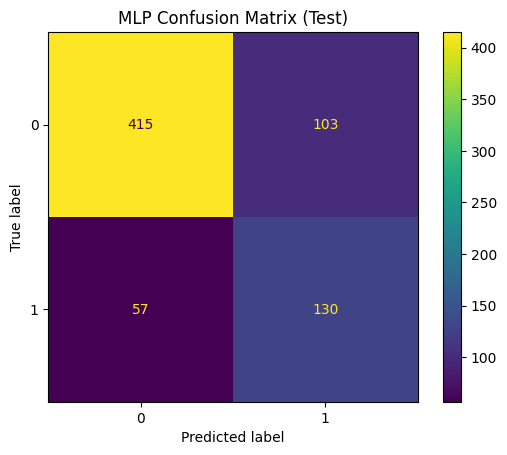

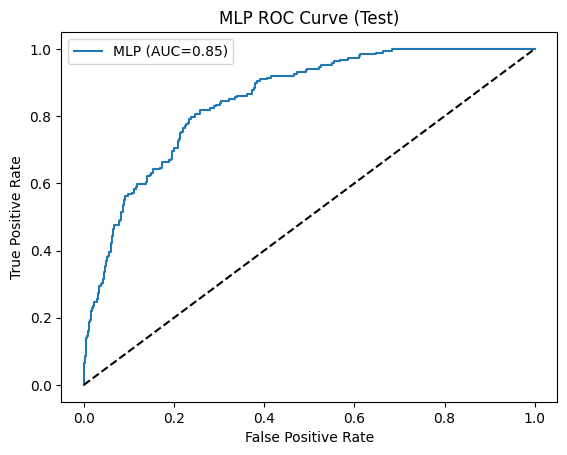

In [8]:
# Multi-Layer Perceptron (MLP) with Optuna hyperparameter tuning (F1-based)
# F1EarlyStopping already defined above; class weights removed
%pip install tensorflow-macos tensorflow-metal
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Deterministic TensorFlow config
tf.keras.utils.set_random_seed(SEED)
try:
    tf.config.experimental.enable_op_determinism()
except Exception:
    pass
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

# Class weights removed (data already oversampled to balance classes)

class F1EarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val, patience=5):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.patience = patience
        self.best_f1 = -1
        self.wait = 0
        self.best_weights = None
        self.stopped_epoch = None
    def on_epoch_end(self, epoch, logs=None):
        preds = (self.model.predict(self.X_val, verbose=0).ravel() > 0.5).astype(int)
        current_f1 = f1_score(self.y_val, preds)
        if current_f1 > self.best_f1:
            self.best_f1 = current_f1
            self.best_weights = self.model.get_weights()
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch + 1
                print(f'Early stopping at epoch {self.stopped_epoch}; best val F1={self.best_f1:.4f}')
                self.model.stop_training = True
            
def create_mlp_model(trial):
    n_layers = trial.suggest_int('n_layers', 2, 4)
    n_units = trial.suggest_int('n_units', 32, 128)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    model = models.Sequential()
    model.add(layers.Input(shape=(X_train_proc.shape[1],)))
    for _ in range(n_layers):
        model.add(layers.Dense(n_units, activation='relu'))
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='sigmoid'))
    optimizer = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=losses.BinaryCrossentropy(), metrics=['accuracy'])
    return model

def objective_mlp(trial):
    model = create_mlp_model(trial)
    f1_callback = F1EarlyStopping(X_val_proc, y_val, patience=5)
    model.fit(
        X_train_proc, y_train,
        validation_data=(X_val_proc, y_val),
        epochs=30,
        batch_size=trial.suggest_int('batch_size', 32, 128),
        verbose=0,
        callbacks=[f1_callback]
    )
    if f1_callback.stopped_epoch is not None:
        print(f'Trial early stopped at epoch {f1_callback.stopped_epoch} (best val F1={f1_callback.best_f1:.4f})')
    if f1_callback.best_weights is not None:
        model.set_weights(f1_callback.best_weights)
    return f1_callback.best_f1

study_mlp = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_mlp.optimize(objective_mlp, n_trials=50, show_progress_bar=True)

best_params_mlp = study_mlp.best_params
print('Best MLP hyperparameters:', best_params_mlp)
best_mlp = create_mlp_model(optuna.trial.FixedTrial(best_params_mlp))
f1_callback_final = F1EarlyStopping(X_val_proc, y_val, patience=5)
best_mlp.fit(
    X_train_proc, y_train,
    validation_data=(X_val_proc, y_val),
    epochs=30,
    batch_size=best_params_mlp['batch_size'],
    verbose=0,
    callbacks=[f1_callback_final]
)
if f1_callback_final.stopped_epoch is not None:
    print(f'Final MLP early stopped at epoch {f1_callback_final.stopped_epoch} (best val F1={f1_callback_final.best_f1:.4f})')
if f1_callback_final.best_weights is not None:
    best_mlp.set_weights(f1_callback_final.best_weights)

pred_test_mlp = best_mlp.predict(X_test_proc).ravel()
pred_test_label_mlp = (pred_test_mlp > 0.5).astype(int)
cm_mlp = confusion_matrix(y_test, pred_test_label_mlp)
roc_auc_mlp = roc_auc_score(y_test, pred_test_mlp)
f1_mlp = f1_score(y_test, pred_test_label_mlp)
precision_mlp = precision_score(y_test, pred_test_label_mlp)
recall_mlp = recall_score(y_test, pred_test_label_mlp)
specificity_mlp = cm_mlp[0,0] / (cm_mlp[0,0] + cm_mlp[0,1]) if (cm_mlp[0,0] + cm_mlp[0,1]) > 0 else 0
accuracy_mlp = (cm_mlp[0,0] + cm_mlp[1,1]) / cm_mlp.sum()
print('MLP Test Results:')
print(f'Accuracy: {accuracy_mlp:.4f}')
print(f'F1 Score: {f1_mlp:.4f}')
print(f'Precision: {precision_mlp:.4f}')
print(f'Recall (Sensitivity): {recall_mlp:.4f}')
print(f'Specificity: {specificity_mlp:.4f}')
print(f'AUC: {roc_auc_mlp:.4f}')
ConfusionMatrixDisplay(cm_mlp).plot()
plt.title('MLP Confusion Matrix (Test)')
plt.show()
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, pred_test_mlp)
plt.figure()
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC={roc_auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP ROC Curve (Test)')
plt.legend()
plt.show()